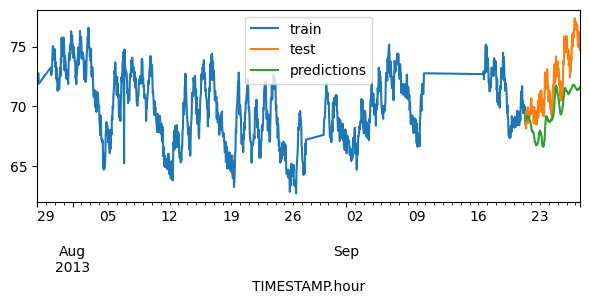

In [1]:
from insight_analyzer import InsightAnalyzer

# notebook input from an insight
sample = InsightAnalyzer(insight_id="657f0cc8-fa05-46bb-9808-8cf4f065ce3d")
pred = sample.predict()

In [2]:
print(pred)

{"index": {"0": "2013-07-28 00:00:00", "1": "2013-07-28 01:00:00", "2": "2013-07-28 02:00:00", "3": "2013-07-28 03:00:00", "4": "2013-07-28 04:00:00", "5": "2013-07-28 05:00:00", "6": "2013-07-28 06:00:00", "7": "2013-07-28 07:00:00", "8": "2013-07-28 08:00:00", "9": "2013-07-28 09:00:00", "10": "2013-07-28 10:00:00", "11": "2013-07-28 11:00:00", "12": "2013-07-28 12:00:00", "13": "2013-07-28 13:00:00", "14": "2013-07-28 14:00:00", "15": "2013-07-28 15:00:00", "16": "2013-07-28 16:00:00", "17": "2013-07-28 17:00:00", "18": "2013-07-28 18:00:00", "19": "2013-07-28 19:00:00", "20": "2013-07-28 20:00:00", "21": "2013-07-28 21:00:00", "22": "2013-07-28 22:00:00", "23": "2013-07-28 23:00:00", "24": "2013-07-29 00:00:00", "25": "2013-07-29 01:00:00", "26": "2013-07-29 02:00:00", "27": "2013-07-29 03:00:00", "28": "2013-07-29 04:00:00", "29": "2013-07-29 05:00:00", "30": "2013-07-29 06:00:00", "31": "2013-07-29 07:00:00", "32": "2013-07-29 08:00:00", "33": "2013-07-29 09:00:00", "34": "2013-0